[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/multilabel-classification-mscoco.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq

In [2]:
# Load cached data
if not os.path.exists("../data"):
    os.system("gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz")
    os.system("tar -xf ../data.tar.gz -C ../")
    os.system("rm ../data.tar.gz")

data = np.load("../data/coco/coco-tresnetxl.npz")
example_paths = os.listdir("../data/coco/examples")

sgmd = data["sgmd"]  # sigmoid scores
labels = data["labels"]
example_indexes = data["example_indexes"]

In [3]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired false negative rate


def false_negative_rate(prediction_set, gt_labels):
    return 1 - ((prediction_set * gt_labels).sum(axis=1) / gt_labels.sum(axis=1)).mean()

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (sgmd.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = sgmd[idx, :], sgmd[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformal risk control happens here

In [5]:
# Run the conformal risk control procedure
def lamhat_threshold(lam):
    return false_negative_rate(cal_sgmd >= lam, cal_labels) - (
        (n + 1) / n * alpha - 1 / (n + 1)
    )


lamhat = brentq(lamhat_threshold, 0, 1)
prediction_sets = val_sgmd >= lamhat

In [6]:
# Calculate empirical FNR
print(
    f"The empirical FNR is: {false_negative_rate(prediction_sets, val_labels)} and the threshold value is: {lamhat}"
)

The empirical FNR is: 0.1038932204246521 and the threshold value is: 0.7599742710572364


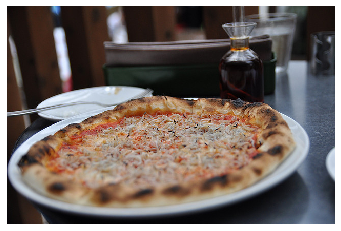

The prediction set is: ['person', 'bench', 'handbag', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'broccoli', 'pizza', 'chair', 'potted plant', 'dining table', 'cell phone', 'book', 'vase']


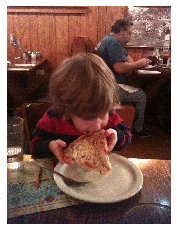

The prediction set is: ['person', 'car', 'bench', 'backpack', 'handbag', 'tie', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'sandwich', 'broccoli', 'carrot', 'pizza', 'cake', 'chair', 'couch', 'potted plant', 'dining table', 'tv', 'cell phone', 'oven', 'sink', 'refrigerator', 'book', 'clock', 'vase']


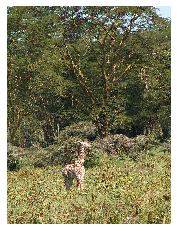

The prediction set is: ['bird', 'elephant', 'zebra', 'giraffe']


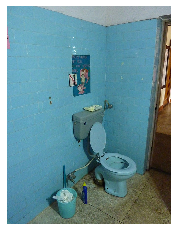

The prediction set is: ['person', 'cat', 'handbag', 'bottle', 'cup', 'bowl', 'toilet', 'sink', 'book', 'toothbrush']


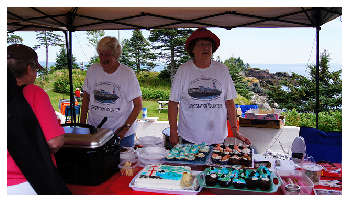

The prediction set is: ['person', 'bicycle', 'car', 'train', 'truck', 'boat', 'bench', 'bird', 'dog', 'horse', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'sports ball', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'carrot', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'dining table', 'tv', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors']


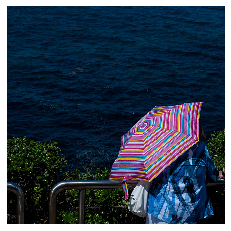

The prediction set is: ['person', 'bicycle', 'boat', 'bench', 'bird', 'backpack', 'umbrella', 'handbag', 'bottle', 'chair', 'cell phone']


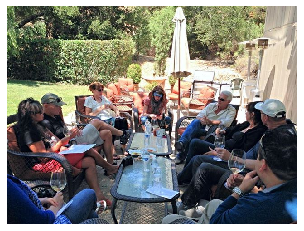

The prediction set is: ['person', 'bicycle', 'car', 'boat', 'bench', 'bird', 'backpack', 'umbrella', 'handbag', 'tie', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'sandwich', 'carrot', 'hot dog', 'pizza', 'cake', 'chair', 'couch', 'potted plant', 'dining table', 'tv', 'laptop', 'remote', 'cell phone', 'book', 'clock', 'vase']


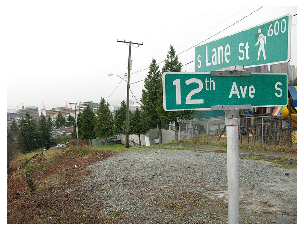

The prediction set is: ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'dog', 'backpack', 'handbag', 'potted plant']


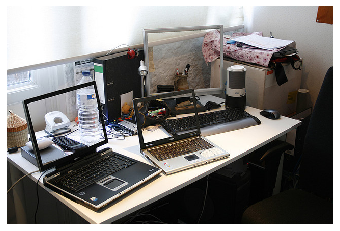

The prediction set is: ['person', 'train', 'cat', 'dog', 'backpack', 'umbrella', 'handbag', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'toothbrush']


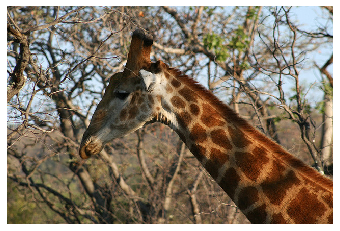

The prediction set is: ['bird', 'zebra', 'giraffe']


In [7]:
# Show some examples
label_strings = np.load("../data/coco/human_readable_labels.npy")

example_paths = os.listdir("../data/coco/examples")
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread("../data/coco/examples/" + rand_path)
    img_index = int(rand_path.split(".")[0])
    prediction_set = sgmd[img_index] > 1 - lamhat
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

This method was first introduced here: https://arxiv.org/abs/2208.02814.